<a href="https://colab.research.google.com/github/AyonChatterjee/ML-Projects-/blob/main/Flight_Price_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install xgboost

#importing dependencies

import numpy as np
import pandas as pd


import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score
from math import sqrt

from sklearn.linear_model import LinearRegression , Lasso , Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVC
from sklearn.preprocessing import OneHotEncoder , LabelEncoder
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

import xgboost as xgb




[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
! pip install openpyxl
train_df = pd.read_excel("Data_Train.xlsx")

train_df.head()


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302


In [4]:
train_df.columns

Index(['Airline', 'Date_of_Journey', 'Source', 'Destination', 'Route',
       'Dep_Time', 'Arrival_Time', 'Duration', 'Total_Stops',
       'Additional_Info', 'Price'],
      dtype='object')

In [5]:
train_df.describe()

,Price
count,10683.000000
mean,9087.064121
std,4611.359167
min,1759.000000
25%,5277.000000
50%,8372.000000
75%,12373.000000
max,79512.000000


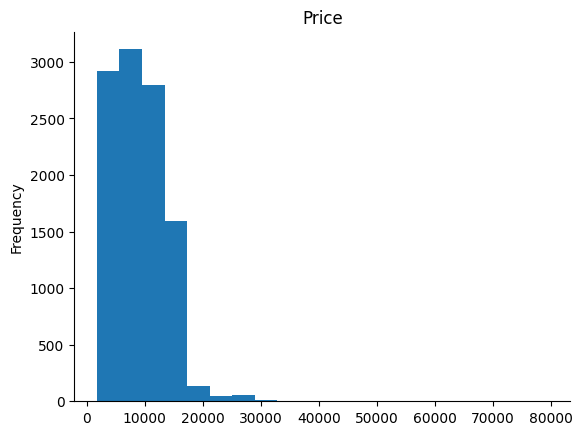

In [6]:
from matplotlib import pyplot as plt
train_df['Price'].plot(kind='hist', bins=20, title='Price')
plt.gca().spines[['top', 'right',]].set_visible(False)

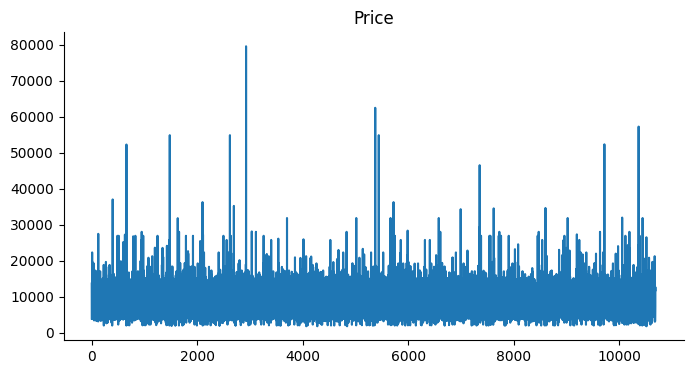

In [7]:
from matplotlib import pyplot as plt
train_df['Price'].plot(kind='line', figsize=(8, 4), title='Price')
plt.gca().spines[['top', 'right']].set_visible(False)

In [8]:
train_df[train_df.isnull().any(axis=1)]

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
9039,Air India,6/05/2019,Delhi,Cochin,NaN,09:45,09:25 07 May,23h 40m,NaN,No info,7480


In [9]:
train_df.isnull().sum()

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              1
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        1
Additional_Info    0
Price              0
dtype: int64

In [10]:
train_df.dropna(inplace = True)
train_df[train_df.duplicated()].head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
683,Jet Airways,1/06/2019,Delhi,Cochin,DEL → NAG → BOM → COK,14:35,04:25 02 Jun,13h 50m,2 stops,No info,13376
1061,Air India,21/05/2019,Delhi,Cochin,DEL → GOI → BOM → COK,22:00,19:15 22 May,21h 15m,2 stops,No info,10231
1348,Air India,18/05/2019,Delhi,Cochin,DEL → HYD → BOM → COK,17:15,19:15 19 May,26h,2 stops,No info,12392
1418,Jet Airways,6/06/2019,Delhi,Cochin,DEL → JAI → BOM → COK,05:30,04:25 07 Jun,22h 55m,2 stops,In-flight meal not included,10368
1674,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,18:25,21:20,2h 55m,non-stop,No info,7303


Removing the repeated values.

In [11]:
train_df.drop_duplicates(keep = 'first' , inplace = True)
train_df.head()
train_df.shape

(10462, 11)

In [12]:
train_df["Airline"].unique()


array(['IndiGo', 'Air India', 'Jet Airways', 'SpiceJet',
       'Multiple carriers', 'GoAir', 'Vistara', 'Air Asia',
       'Vistara Premium economy', 'Jet Airways Business',
       'Multiple carriers Premium economy', 'Trujet'], dtype=object)

In [13]:
train_df["Route"].unique()

array(['BLR → DEL', 'CCU → IXR → BBI → BLR', 'DEL → LKO → BOM → COK',
       'CCU → NAG → BLR', 'BLR → NAG → DEL', 'CCU → BLR',
       'BLR → BOM → DEL', 'DEL → BOM → COK', 'DEL → BLR → COK',
       'MAA → CCU', 'CCU → BOM → BLR', 'DEL → AMD → BOM → COK',
       'DEL → PNQ → COK', 'DEL → CCU → BOM → COK', 'BLR → COK → DEL',
       'DEL → IDR → BOM → COK', 'DEL → LKO → COK',
       'CCU → GAU → DEL → BLR', 'DEL → NAG → BOM → COK',
       'CCU → MAA → BLR', 'DEL → HYD → COK', 'CCU → HYD → BLR',
       'DEL → COK', 'CCU → DEL → BLR', 'BLR → BOM → AMD → DEL',
       'BOM → DEL → HYD', 'DEL → MAA → COK', 'BOM → HYD',
       'DEL → BHO → BOM → COK', 'DEL → JAI → BOM → COK',
       'DEL → ATQ → BOM → COK', 'DEL → JDH → BOM → COK',
       'CCU → BBI → BOM → BLR', 'BLR → MAA → DEL',
       'DEL → GOI → BOM → COK', 'DEL → BDQ → BOM → COK',
       'CCU → JAI → BOM → BLR', 'CCU → BBI → BLR', 'BLR → HYD → DEL',
       'DEL → TRV → COK', 'CCU → IXR → DEL → BLR',
       'DEL → IXU → BOM → COK', 'CCU 

In [14]:
#Testing the data

test_df = pd.read_excel("Test_set.xlsx")
test_df.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info
0,Jet Airways,6/06/2019,Delhi,Cochin,DEL → BOM → COK,17:30,04:25 07 Jun,10h 55m,1 stop,No info
1,IndiGo,12/05/2019,Kolkata,Banglore,CCU → MAA → BLR,06:20,10:20,4h,1 stop,No info
2,Jet Airways,21/05/2019,Delhi,Cochin,DEL → BOM → COK,19:15,19:00 22 May,23h 45m,1 stop,In-flight meal not included
3,Multiple carriers,21/05/2019,Delhi,Cochin,DEL → BOM → COK,08:00,21:00,13h,1 stop,No info
4,Air Asia,24/06/2019,Banglore,Delhi,BLR → DEL,23:55,02:45 25 Jun,2h 50m,non-stop,No info


In [15]:
test_df.columns

Index(['Airline', 'Date_of_Journey', 'Source', 'Destination', 'Route',
       'Dep_Time', 'Arrival_Time', 'Duration', 'Total_Stops',
       'Additional_Info'],
      dtype='object')

In [16]:
test_df.describe()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info
count,2671,2671,2671,2671,2671,2671,2671,2671,2671,2671
unique,11,44,5,6,100,199,704,320,5,6
top,Jet Airways,9/05/2019,Delhi,Cochin,DEL → BOM → COK,10:00,19:00,2h 50m,1 stop,No info
freq,897,144,1145,1145,624,62,113,122,1431,2148


In [17]:
test_df.isnull().sum()

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              0
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        0
Additional_Info    0
dtype: int64

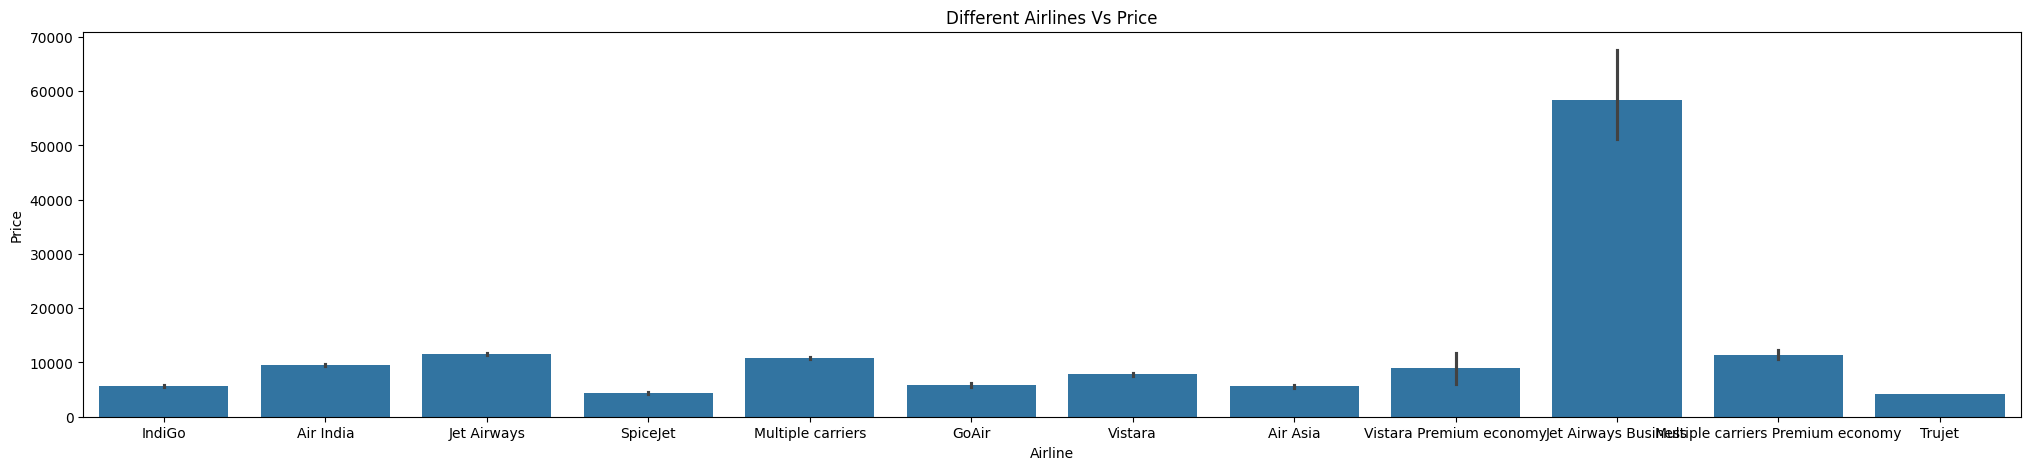

In [18]:
plt.figure(figsize=(25 , 5))
sns.barplot(x = "Airline" , y = "Price" , data = train_df)
plt.title("Different Airlines Vs Price")

plt.show()


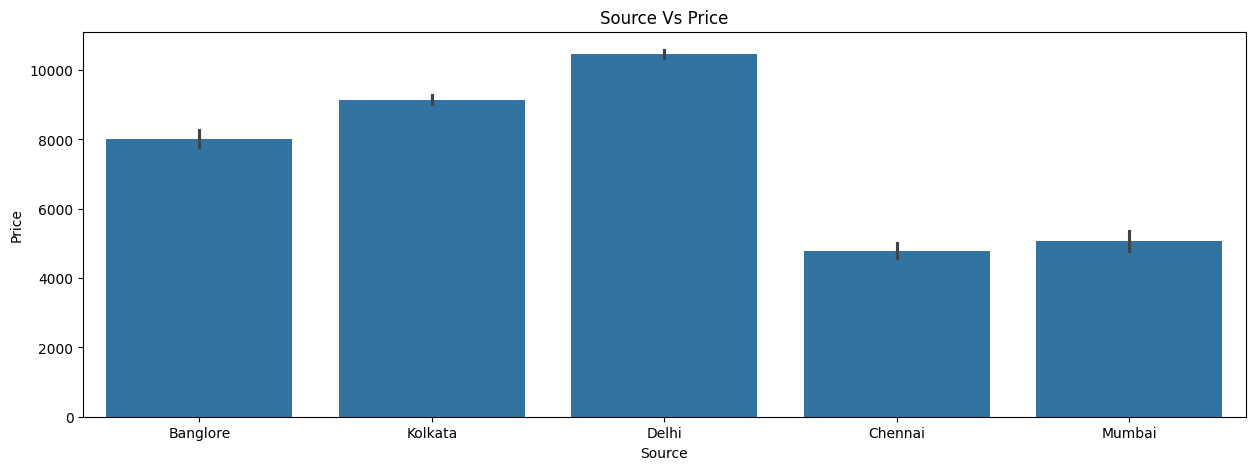

In [19]:
plt.figure(figsize=(15 , 5))
sns.barplot(x = "Source" , y = "Price" , data = train_df)
plt.title("Source Vs Price")
plt.show()


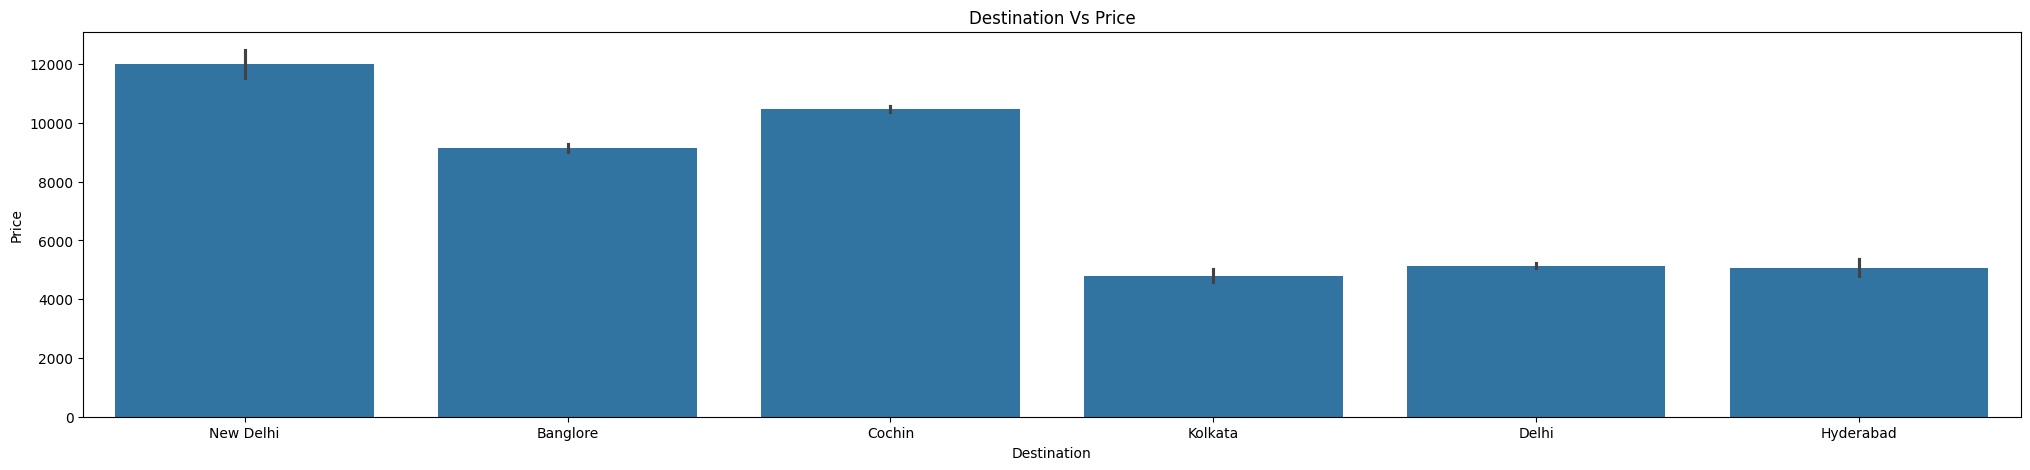

In [20]:
plt.figure(figsize=(25 , 5))
sns.barplot(x = "Destination" , y = "Price" , data = train_df)
plt.title("Destination Vs Price")
plt.show()


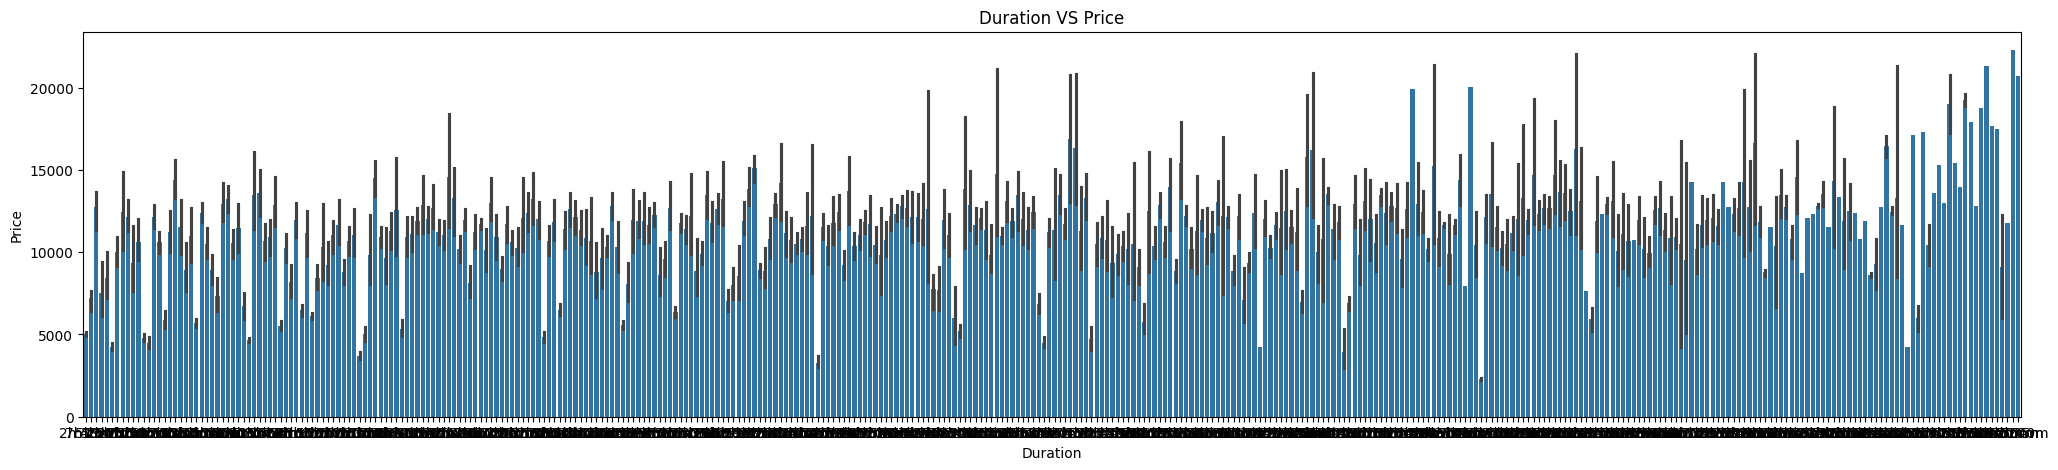

In [21]:
plt.figure(figsize=(25 , 5))
sns.barplot(x = "Duration" , y = "Price" , data = train_df)
plt.title("Duration VS Price")
plt.show()


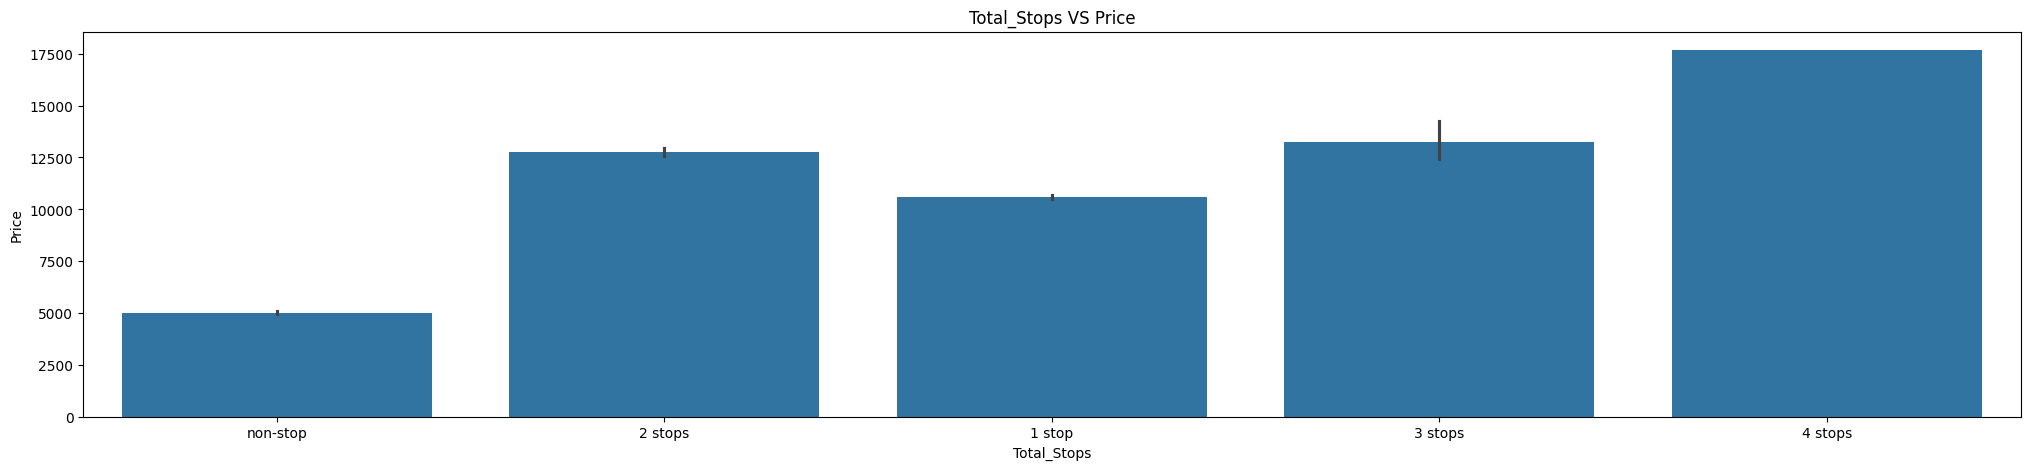

In [22]:
plt.figure(figsize=(25 , 5))
sns.barplot(x = "Total_Stops" , y = "Price" , data = train_df)
plt.title("Total_Stops VS Price")
plt.show()


We are going to change the formats of some of the columns of our data set.

Changing the format of the "Duration" to minutes only .

In [23]:
train_df['Duration'] = train_df['Duration'].astype(str).str.replace("h", '*60').str.replace(' ','+').str.replace('m','*1').apply(eval)
test_df['Duration'] = test_df['Duration'].astype(str).str.replace("h" , '*60').str.replace(' ','+').str.replace('m','*1').apply(eval)

Changing the format of "Date_of_Journey" into day and month.

In [24]:
train_df["Journey_Day"] = train_df['Date_of_Journey'].str.split('/').str[0]
train_df["Journey_Month"] = train_df['Date_of_Journey'].str.split('/').str[1]
train_df.drop(["Date_of_Journey"] , axis = 1 , inplace = True)

Changing the format of "Dep_Time" into min and hour.

In [25]:
train_df["Dep_Hour"] = train_df['Dep_Time'].str.split(':').str[0]
train_df["Dep_Min"] = train_df['Dep_Time'].str.split(':').str[1]
train_df.drop(["Dep_Time"] , axis = 1 , inplace = True)

Changing the format of "Arrival_Time" into min and hour.

In [26]:
train_df["Arrival_Hour"] = train_df['Arrival_Time'].str.split(':').str[0]
train_df["Arrival_Min"] = train_df['Arrival_Time'].str.split(':').str[1]
train_df.drop(["Arrival_Time"] , axis = 1 , inplace = True)

In [27]:
train_df.head()

,Airline,Source,Destination,Route,Duration,Total_Stops,Additional_Info,Price,Journey_Day,Journey_Month,Dep_Hour,Dep_Min,Arrival_Hour,Arrival_Min
0,IndiGo,Banglore,New Delhi,BLR → DEL,170,non-stop,No info,3897,24,03,22,20,01,10 22 Mar
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,445,2 stops,No info,7662,1,05,05,50,13,15
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,1140,2 stops,No info,13882,9,06,09,25,04,25 10 Jun
3,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,325,1 stop,No info,6218,12,05,18,05,23,30
4,IndiGo,Banglore,New Delhi,BLR → NAG → DEL,285,1 stop,No info,13302,01,03,16,50,21,35


In [28]:
train_df.columns

Index(['Airline', 'Source', 'Destination', 'Route', 'Duration', 'Total_Stops',
       'Additional_Info', 'Price', 'Journey_Day', 'Journey_Month', 'Dep_Hour',
       'Dep_Min', 'Arrival_Hour', 'Arrival_Min'],
      dtype='object')

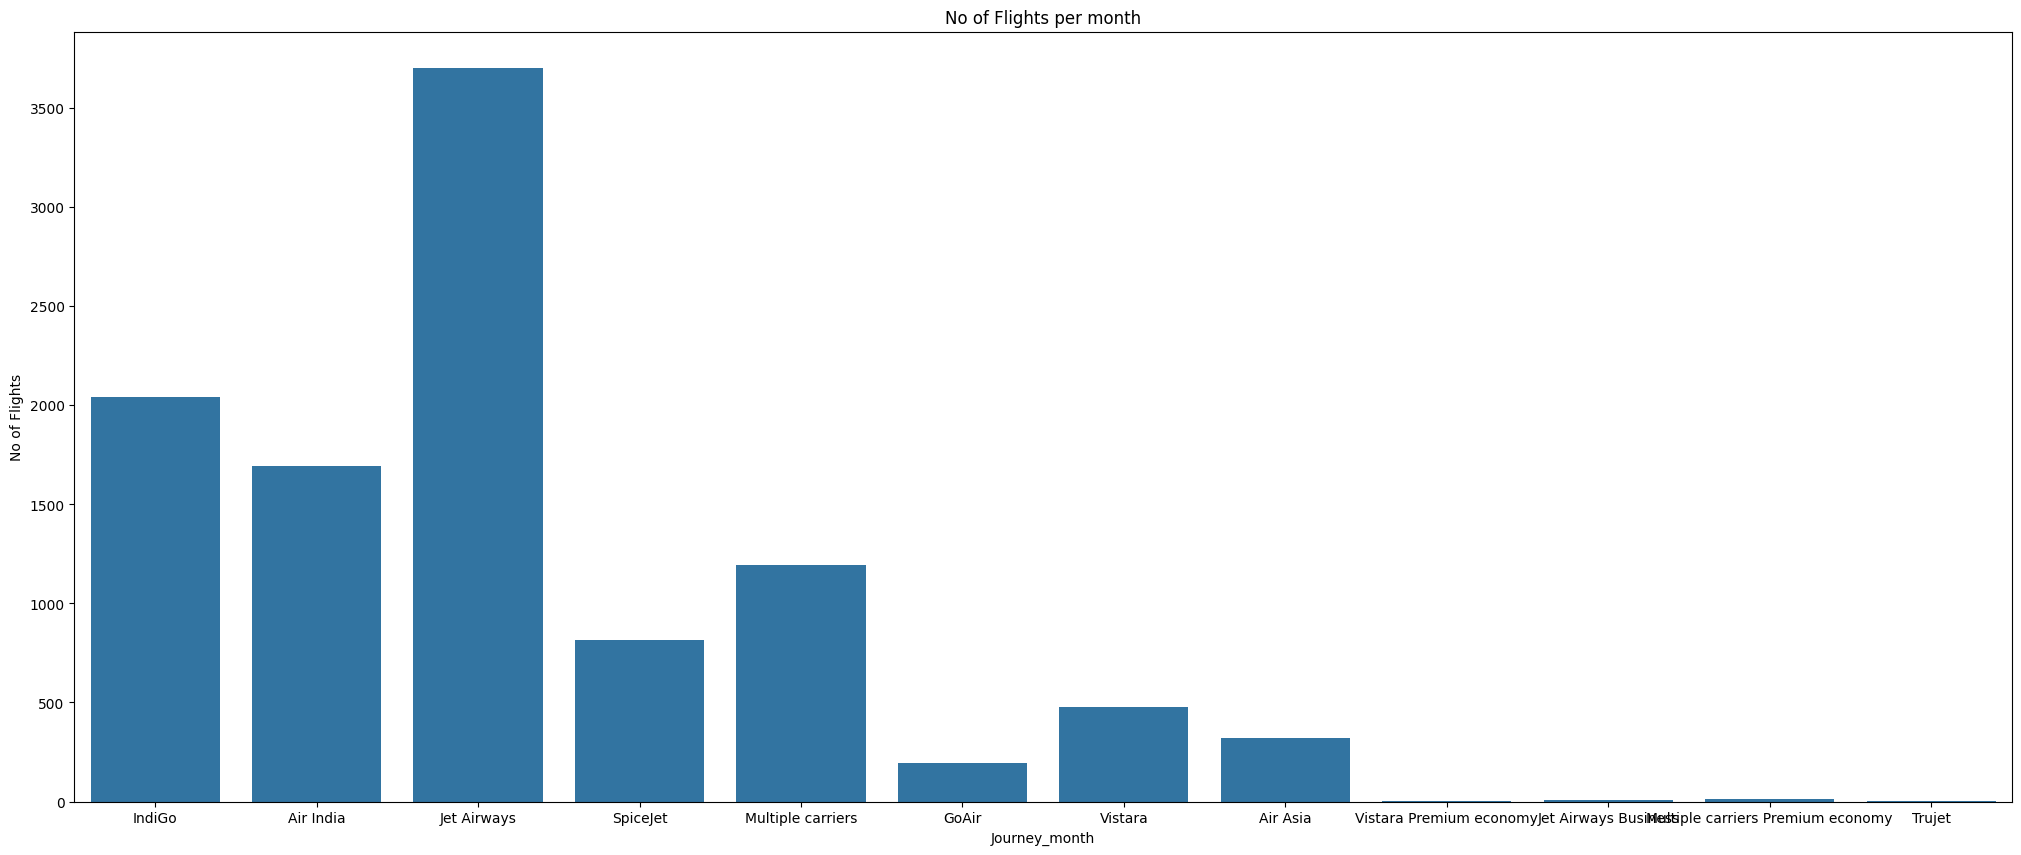

In [29]:
plt.figure(figsize=(25 , 10))

sns.countplot(x = "Airline" , data = train_df)
plt.xlabel("Journey_month")
plt.ylabel("No of Flights")
plt.title("No of Flights per month")
plt.show()

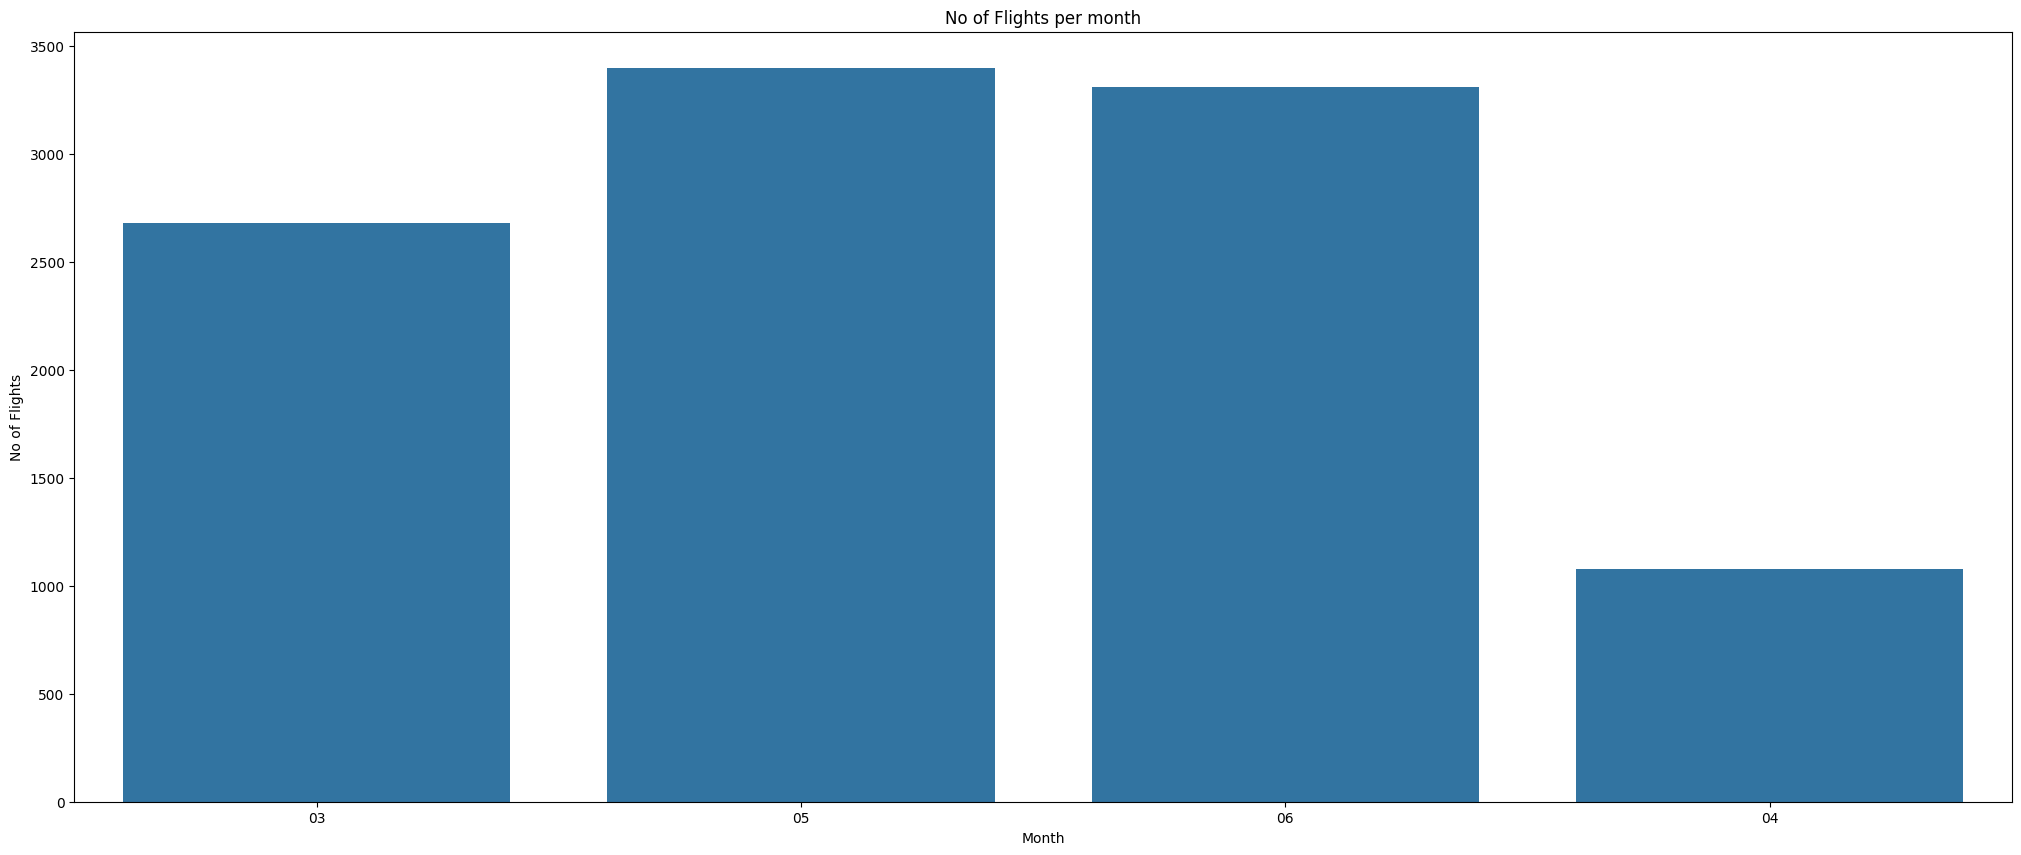

In [30]:
plt.figure(figsize=(25 , 10))
sns.countplot(x = "Journey_Month" , data = train_df)
plt.xlabel("Month")
plt.ylabel("No of Flights")
plt.title("No of Flights per month")
plt.show()

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 [Text(0, 0, 'IndiGo'),
  Text(1, 0, 'Air India'),
  Text(2, 0, 'Jet Airways'),
  Text(3, 0, 'SpiceJet'),
  Text(4, 0, 'Multiple carriers'),
  Text(5, 0, 'GoAir'),
  Text(6, 0, 'Vistara'),
  Text(7, 0, 'Air Asia'),
  Text(8, 0, 'Vistara Premium economy'),
  Text(9, 0, 'Jet Airways Business'),
  Text(10, 0, 'Multiple carriers Premium economy'),
  Text(11, 0, 'Trujet')])

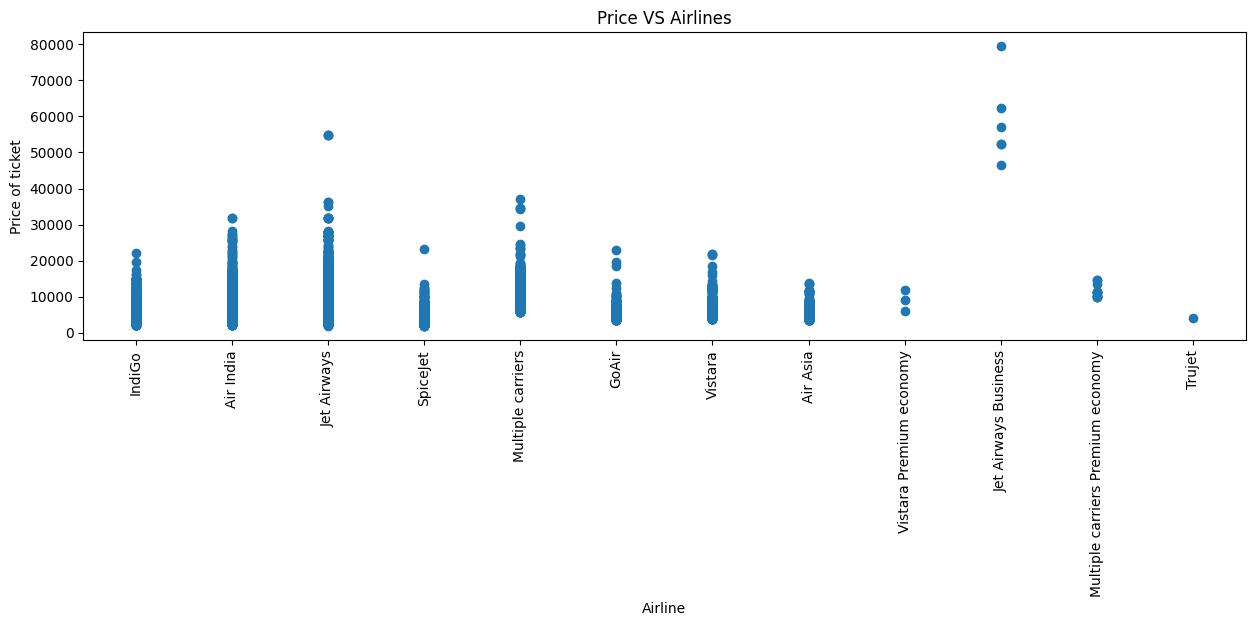

In [31]:
plt.figure(figsize = (15,4))
plt.title('Price VS Airlines')
plt.scatter(train_df['Airline'], train_df['Price'])
plt.xticks
plt.xlabel('Airline')
plt.ylabel('Price of ticket')
plt.xticks(rotation = 90)

In [32]:
#calculating Mean Absolute Percentage Error
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [33]:
data = train_df.drop(["Price"] , axis = 1)

In [34]:
train_categorical_data = data.select_dtypes(exclude=['int64', 'float','int32'])
train_numerical_data = data.select_dtypes(include=['int64', 'float','int32'])

test_categorical_data = test_df.select_dtypes(exclude=['int64', 'float','int32','int32'])
test_numerical_data  = test_df.select_dtypes(include=['int64', 'float','int32'])
train_categorical_data.head()

,Airline,Source,Destination,Route,Total_Stops,Additional_Info,Journey_Day,Journey_Month,Dep_Hour,Dep_Min,Arrival_Hour,Arrival_Min
0,IndiGo,Banglore,New Delhi,BLR → DEL,non-stop,No info,24,03,22,20,01,10 22 Mar
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,2 stops,No info,1,05,05,50,13,15
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,2 stops,No info,9,06,09,25,04,25 10 Jun
3,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,1 stop,No info,12,05,18,05,23,30
4,IndiGo,Banglore,New Delhi,BLR → NAG → DEL,1 stop,No info,01,03,16,50,21,35


In [35]:
le = LabelEncoder()
train_categorical_data = train_categorical_data.apply(LabelEncoder().fit_transform)
test_categorical_data = test_categorical_data.apply(LabelEncoder().fit_transform)
train_categorical_data.head()

,Airline,Source,Destination,Route,Total_Stops,Additional_Info,Journey_Day,Journey_Month,Dep_Hour,Dep_Min,Arrival_Hour,Arrival_Min
0,3,0,5,18,4,8,9,0,22,4,1,101
1,1,3,0,84,1,8,4,2,5,10,13,109
2,4,2,1,118,1,8,13,3,9,5,4,206
3,3,3,0,91,0,8,5,2,18,1,23,237
4,3,0,5,29,0,8,0,0,16,10,21,265


In [36]:
X = pd.concat([train_categorical_data , train_numerical_data] , axis = 1)
Y = train_df["Price"]
test_set = pd.concat([test_categorical_data , test_numerical_data] , axis = 1)

In [37]:
X.head()

,Airline,Source,Destination,Route,Total_Stops,Additional_Info,Journey_Day,Journey_Month,Dep_Hour,Dep_Min,Arrival_Hour,Arrival_Min,Duration
0,3,0,5,18,4,8,9,0,22,4,1,101,170
1,1,3,0,84,1,8,4,2,5,10,13,109,445
2,4,2,1,118,1,8,13,3,9,5,4,206,1140
3,3,3,0,91,0,8,5,2,18,1,23,237,325
4,3,0,5,29,0,8,0,0,16,10,21,265,285


In [38]:
Y.head()

0     3897
1     7662
2    13882
3     6218
4    13302
Name: Price, dtype: int64

In [39]:
def mean_absolute_percentage_error(y_true , y_pred):
  y_true , y_pred = np.array(y_true) , np.array(y_pred)
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [40]:
X_train , X_test , Y_train , Y_test = train_test_split(X , Y , test_size = 0.3 , random_state = 42)

In [41]:
print("The size of training input is", X_train.shape)
print("The size of training output is", Y_train.shape)
print("The size of testing input is", X_test.shape)
print("The size of testing output is", Y_test.shape)

The size of training input is (7323, 13)
The size of training output is (7323,)
The size of testing input is (3139, 13)
The size of testing output is (3139,)


Now , we will do the model building.

Lasso Regression

In [42]:
params = {'alpha' : [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000]}
lasso_regressor = GridSearchCV(Lasso(), params ,cv = 15,scoring = 'neg_mean_absolute_error', n_jobs = -1)
lasso_regressor.fit(X_train, Y_train)

GridSearchCV(cv=15, estimator=Lasso(), n_jobs=-1,
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000,
                                   10000, 100000]},
             scoring='neg_mean_absolute_error')

In [43]:
y_train_pred = lasso_regressor.predict(X_train)
y_test_pred = lasso_regressor.predict(X_test)

In [44]:
print("Train Results for Lasso Regression Model:")
print("Root Mean Squared Error: ", sqrt(mse(Y_train.values, y_train_pred)))
print("Mean Absolute % Error: ", round(mean_absolute_percentage_error(Y_train.values, y_train_pred)))
print("R-Squared: ", r2_score(Y_train.values, y_train_pred))

Train Results for Lasso Regression Model:
Root Mean Squared Error:  3608.4604281022503
Mean Absolute % Error:  32
R-Squared:  0.398569318210658


In [45]:
print("Test Results for Lasso Regression Model:")
print("Root Mean Squared Error: ", sqrt(mse(Y_test.values, y_test_pred)))
print("Mean Absolute % Error: ", round(mean_absolute_percentage_error(Y_test.values, y_test_pred)))
print("R-Squared: ", r2_score(Y_test.values, y_test_pred))

Test Results for Lasso Regression Model:
Root Mean Squared Error:  3505.6928677078954
Mean Absolute % Error:  32
R-Squared:  0.40824665776480096


Ridge Regression

In [46]:
params = {'alpha' : [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000]}
ridge_regressor = GridSearchCV(Ridge(), params, cv = 5, scoring = 'neg_mean_absolute_error', n_jobs = -1)
ridge_regressor.fit(X_train, Y_train)

GridSearchCV(cv=5, estimator=Ridge(), n_jobs=-1,
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000,
                                   10000, 100000]},
             scoring='neg_mean_absolute_error')

In [47]:
y_train_pred = ridge_regressor.predict(X_train)
y_test_pred = ridge_regressor.predict(X_test)

In [48]:
print("Train Results for Ridge Regression Model:")
print("Root Mean Squared Error: ", sqrt(mse(Y_train.values, y_train_pred)))
print("Mean Absolute % Error: ", round(mean_absolute_percentage_error(Y_train.values, y_train_pred)))
print("R-Squared: ", r2_score(Y_train.values, y_train_pred))

Train Results for Ridge Regression Model:
Root Mean Squared Error:  3606.2237139402696
Mean Absolute % Error:  32
R-Squared:  0.3993146840686992


In [49]:
print("Test Results for Ridge Regression Model:")
print("Root Mean Squared Error: ", sqrt(mse(Y_test.values, y_test_pred)))
print("Mean Absolute % Error: ", round(mean_absolute_percentage_error(Y_test.values, y_test_pred)))
print("R-Squared: ", r2_score(Y_test.values, y_test_pred))

Test Results for Ridge Regression Model:
Root Mean Squared Error:  3504.705555434829
Mean Absolute % Error:  32
R-Squared:  0.4085799231640366


Decision Tree Model

In [50]:
depth = list(range(3,30))
param_grid = dict(max_depth = depth)
tree = GridSearchCV(DecisionTreeRegressor(), param_grid, cv = 10)
tree.fit(X_train,Y_train)

GridSearchCV(cv=10, estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14,
                                       15, 16, 17, 18, 19, 20, 21, 22, 23, 24,
                                       25, 26, 27, 28, 29]})

In [51]:
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)

In [52]:
print("Train Results for Decision Tree Model:")
print("Root Mean squared Error: ", sqrt(mse(Y_train.values, y_train_pred)))
print("Mean Absolute % Error: ", round(mean_absolute_percentage_error(Y_train.values, y_train_pred)))
print("R-Squared: ", r2_score(Y_train.values, y_train_pred))

Train Results for Decision Tree Model:
Root Mean squared Error:  695.0638394081675
Mean Absolute % Error:  4
R-Squared:  0.9776852988100224


In [53]:
print("Test Results for Decision Tree Model:")
print("Root Mean squared Error: ", sqrt(mse(Y_test.values, y_test_pred)))
print("Mean Absolute % Error: ", round(mean_absolute_percentage_error(Y_test.values, y_test_pred)))
print("R-Squared: ", r2_score(Y_test.values, y_test_pred))

Test Results for Decision Tree Model:
Root Mean squared Error:  1911.4422048675858
Mean Absolute % Error:  10
R-Squared:  0.8240799533636329


Linear Regression Model

In [54]:
alphas = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
param_grid = {'alpha': alphas}

ridge = Ridge()

ridge_grid = GridSearchCV(estimator=ridge, param_grid=param_grid, cv=10)
ridge_grid.fit(X_train, Y_train)

GridSearchCV(cv=10, estimator=Ridge(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000,
                                   10000]})

In [55]:
y_train_pred = ridge_grid.predict(X_train)
y_test_pred = ridge_grid.predict(X_test)

In [56]:
print("Train Results for Linear Regression Model:")
print("Root Mean Squared Error: ", sqrt(mse(Y_train.values, y_train_pred)))
print("Mean Absolute % Error: ", round(mean_absolute_percentage_error(Y_train.values, y_train_pred)))
print("R-Squared: ", r2_score(Y_train.values, y_train_pred))

Train Results for Linear Regression Model:
Root Mean Squared Error:  3603.931004267067
Mean Absolute % Error:  32
R-Squared:  0.4000782302915512


In [57]:
print("Test Results for Linear Regression Model:")
print("Root Mean Squared Error: ", sqrt(mse(Y_test.values, y_test_pred)))
print("Mean Absolute % Error: ", round(mean_absolute_percentage_error(Y_test.values, y_test_pred)))
print("R-Squared: ", r2_score(Y_test.values, y_test_pred))

Test Results for Linear Regression Model:
Root Mean Squared Error:  3503.8951110871203
Mean Absolute % Error:  32
R-Squared:  0.40885341697487276


XGboost Model


In [58]:
param_grid = {
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
}

model = xgb.XGBRegressor()

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, Y_train)


c:\Users\chatt\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_search.py:1103: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan]
  warnings.warn(


GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 4, 5],
                         'n_estimators': [100, 200, 300]},
             scoring='accuracy')

In [59]:
y_train_pred = grid_search.predict(X_train)
y_test_pred  = grid_search.predict(X_test)

In [60]:
print("Train Results for XGBRegressor Model:")
print("Root Mean Squared Error: ", sqrt(mse(Y_train.values, y_train_pred)))
print("Mean Absolute % Error: ", round(mean_absolute_percentage_error(Y_train.values, y_train_pred)))
print("R-Squared: ", r2_score(Y_train.values, y_train_pred))

Train Results for XGBRegressor Model:
Root Mean Squared Error:  3259.888747199157
Mean Absolute % Error:  33
R-Squared:  0.5091516971588135


In [61]:
print("Test Results for XGBRegressor Model:")
print("Root Mean Squared Error: ", sqrt(mse(Y_test.values, y_test_pred)))
print("Mean Absolute % Error: ", round(mean_absolute_percentage_error(Y_test.values, y_test_pred)))
print("R-Squared: ", r2_score(Y_test.values, y_test_pred))

Test Results for XGBRegressor Model:
Root Mean Squared Error:  3158.1781468929275
Mean Absolute % Error:  34
R-Squared:  0.5197513103485107


Random Forest

In [62]:
model = RandomForestRegressor()

model.fit(X_train , Y_train)

RandomForestRegressor()

In [71]:
model = RandomForestRegressor(max_samples=0.75 , random_state=42)
model.fit(X_train , Y_train)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

In [72]:
print("Train Results for RandomForest Model:")
print("Root Mean Squared Error: ", sqrt(mse(Y_train.values, y_train_pred)))
print("Mean Absolute % Error: ", round(mean_absolute_percentage_error(Y_train.values, y_train_pred)))
print("R-Squared: ", r2_score(Y_train.values, y_train_pred))

Train Results for RandomForest Model:
Root Mean Squared Error:  894.8155427677088
Mean Absolute % Error:  4
R-Squared:  0.9630164391204237


In [ ]:
print("Test Results for RandomForest Model:")
print("Root Mean Squared Error: ", sqrt(mse(Y_test.values, y_test_pred)))
print("Mean Absolute % Error: ", round(mean_absolute_percentage_error(Y_test.values, y_test_pred)))
print("R-Squared: ", r2_score(Y_test.values, y_test_pred))
print()

Test Results for RandomForest Model:
Root Mean Squared Error:  1583.861823798912
Mean Absolute % Error:  9
R-Squared:  0.8792109483690798


Comparison between all the Models Used

In [67]:
lasso_score = round(lasso_regressor.score(X_train, Y_train) * 100, 2)
lasso_score_test = round(lasso_regressor.score(X_test, Y_test) * 100, 2)

ridge_score = round(ridge_regressor.score(X_train, Y_train) * 100, 2)
ridge_score_test = round(ridge_regressor.score(X_test, Y_test) * 100, 2)

decision_score = round(tree.score(X_train, Y_train) * 100, 2)
decision_score_test = round(tree.score(X_test, Y_test) * 100, 2)

linear_score = round(ridge_grid.score(X_train, Y_train) * 100, 2)
linear_score_test = round(ridge_grid.score(X_test, Y_test) * 100, 2)

random_score = round(model.score(X_train, Y_train) * 100, 2)
random_score_test = round(model.score(X_test, Y_test) * 100, 2)


In [68]:
print(f"Lasso Regression - Training Score: {lasso_score}%")
print(f"Lasso Regression - Test Score: {lasso_score_test}%\n")


print(f"Ridge Regression - Training Score: {ridge_score}%")
print(f"Ridge Regression - Test Score: {ridge_score_test}%\n")


print(f"Linear Regression - Training Score: {linear_score}%")
print(f"Linear Regression - Testing Score: {linear_score_test}%\n")


print(f"Decision Tree - Training Score: {decision_score}%")
print(f"Decision Tree - Test Score: {decision_score_test}%\n")


print(f"Random Forest - Training Score: {random_score}%")
print(f"Random Forest - Testing Score: {random_score_test}%")


Lasso Regression - Training Score: -254305.1%
Lasso Regression - Test Score: -249985.23%

Ridge Regression - Training Score: -254884.38%
Ridge Regression - Test Score: -250633.54%

Linear Regression - Training Score: 40.01%
Linear Regression - Testing Score: 40.89%

Decision Tree - Training Score: 97.77%
Decision Tree - Test Score: 82.41%

Random Forest - Training Score: 96.3%
Random Forest - Testing Score: 87.92%


In [69]:
models = ['Linear Regression', 'Decision Tree', 'Random Forest']
training_scores = [40.01, 97.77, 97.86]
test_scores = [40.89, 81.26, 87.76]


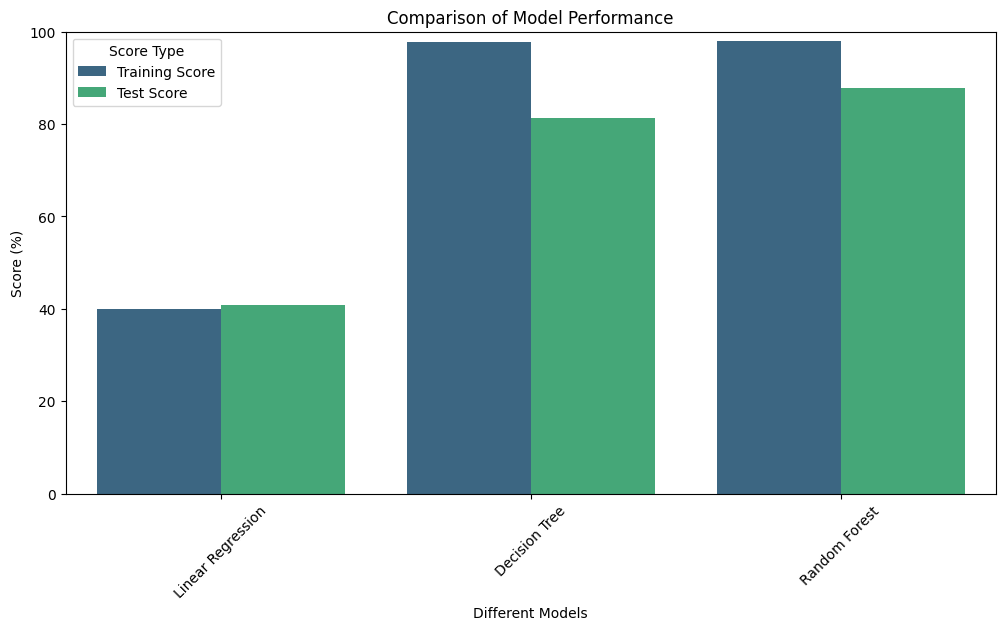

In [70]:
df = pd.DataFrame({
    'Model': models,
    'Training Score': training_scores,
    'Test Score': test_scores
})

plt.figure(figsize=(12, 6))
sns.barplot(x='Model', y='value', hue='variable',
            data=pd.melt(df, id_vars='Model', value_vars=['Training Score', 'Test Score']),
            palette='viridis')

plt.title('Comparison of Model Performance')
plt.ylabel('Score (%)')
plt.xlabel('Different Models')
plt.ylim(0, 100)
plt.legend(title='Score Type')
plt.xticks(rotation=45)
plt.show()
